# <center>Two Sigma: Using News to Predict Stock Movements</center>
---

![](http://i65.tinypic.com/2im5eno.jpg)

## Introductions :
Can we use the content of news analytics to predict stock price performance? The ubiquity of data today enables investors at any scale to make better investment decisions. The challenge is ingesting and interpreting the data to determine which data is useful, finding the signal in this sea of information. Two Sigma is passionate about this challenge and is excited to share it with the Kaggle community.

As a scientifically driven investment manager, Two Sigma has been applying technology and data science to financial forecasts for over 17 years. Their pioneering advances in big data, AI, and machine learning have pushed the investment industry forward. Now, they're eager to engage with Kagglers in this continuing pursuit of innovation.

By analyzing news data to predict stock prices, Kagglers have a unique opportunity to advance the state of research in understanding the predictive power of the news. This power, if harnessed, could help predict financial outcomes and generate significant economic impact all over the world.

## General information

Two Sigma : Using News to Predict Stock Movements Competition is a unique competitions :
 - it is a Kernel-only competition, but we aren't supposed to 
 - we cannot download data outside Kaggle
 - Our solution are locked for stage two to predict future real data.
 ---

# Data Description

### Market data (2007 to present) provided by Intrinio
It contains financial market information such as opening price, closing price, trading volume, calculated returns, etc.

### News data (2007 to present) Source: Thomson Reuters

It contains information about news articles/alerts published about assets, such as article details, sentiment, and other commentary.

### Getting data and importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

import random
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from datetime import datetime, date
from skopt.plots import plot_convergence
from skopt import gp_minimize

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



## Auxiliary functions

In [2]:
def mis_impute(data):
    for i in data.columns:
        if data[i].dtype == "object":
            data[i] = data[i].fillna("other")
        elif (data[i].dtype == "int64" or data[i].dtype == "float64"):
            data[i] = data[i].fillna(data[i].mean())
        else:
            pass
    return data

def data_prep(market_train):
    market_train.time = market_train.time.dt.date
    lbl = {k: v for v, k in enumerate(market_train['assetCode'].unique())}
    market_train['assetCodeT'] = market_train['assetCode'].map(lbl)
    
    market_train = market_train.dropna(axis=0)
    
    return market_train

In [3]:
# official way to get the data
from kaggle.competitions import twosigmanews
env = twosigmanews.make_env()

Loading the data... This could take a minute.
Done!


In [5]:
market_train_df, news_train_df = env.get_training_data()
market_train = market_train_df.copy()
market_train = data_prep(mis_impute(market_train))

We have two datasets, let's explore them separately.

## Market data

This dataset contains stock prices for many companies over a decade.
 Let have a look on the long-term trends, appearing and declining companies and many other things.

In [6]:
print(f'{market_train_df.shape[0]} samples and {market_train_df.shape[1]} features in the training market dataset.')

4072956 samples and 16 features in the training market dataset.


In [39]:
market_train_df.head()

time         ...          assetName_mean_close
732812 2009-01-02 22:00:00+00:00         ...                     38.607230
732813 2009-01-02 22:00:00+00:00         ...                      7.021656
732814 2009-01-02 22:00:00+00:00         ...                     84.301749
732815 2009-01-02 22:00:00+00:00         ...                    262.096429
732816 2009-01-02 22:00:00+00:00         ...                     34.427734

[5 rows x 20 columns]

Let's take 10 random assets and plot them.

In [8]:
data = []
for asset in np.random.choice(market_train_df['assetName'].unique(), 15):
    asset_df = market_train_df[(market_train_df['assetName'] == asset)]

    data.append(go.Scatter(
        x = asset_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = asset_df['close'].values,
        name = asset
    ))
layout = go.Layout(dict(title = "Closing prices of 15 random assets",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

Assets are sampled randomly, and you should see that some stocks started trading later, some dissappeared. 
Disappearence could be due to bankruptcy, acquisition or other reasons.

Let 's see the general trends of prices.

In [9]:
data = []
for i in [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
    price_df = market_train_df.groupby('time')['close'].quantile(i).reset_index()

    data.append(go.Scatter(
        x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = price_df['close'].values,
        name = f'{i} quantile'
    ))
layout = go.Layout(dict(title = "Trends of closing prices by quantiles",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"),
    annotations=[
        dict(
            x='2008-09-01 22:00:00+0000',
            y=82,
            xref='x',
            yref='y',
            text='Collapse of Lehman Brothers',
            showarrow=True,
            font=dict(
                family='Courier New, monospace',
                size=16,
                color='#ffffff'
            ),
            align='center',
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='#636363',
            ax=20,
            ay=-30,
            bordercolor='#c7c7c7',
            borderwidth=2,
            borderpad=4,
            bgcolor='#ff7f0e',
            opacity=0.8
        ),
        dict(
            x='2011-08-01 22:00:00+0000',
            y=85,
            xref='x',
            yref='y',
            text='Black Monday',
            showarrow=True,
            font=dict(
                family='Courier New, monospace',
                size=16,
                color='#ffffff'
            ),
            align='center',
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='#636363',
            ax=20,
            ay=-30,
            bordercolor='#c7c7c7',
            borderwidth=2,
            borderpad=4,
            bgcolor='#ff7f0e',
            opacity=0.8
        ),
        dict(
            x='2014-10-01 22:00:00+0000',
            y=120,
            xref='x',
            yref='y',
            text='Another crisis',
            showarrow=True,
            font=dict(
                family='Courier New, monospace',
                size=16,
                color='#ffffff'
            ),
            align='center',
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='#636363',
            ax=-20,
            ay=-30,
            bordercolor='#c7c7c7',
            borderwidth=2,
            borderpad=4,
            bgcolor='#ff7f0e',
            opacity=0.8
        ),
        dict(
            x='2016-01-01 22:00:00+0000',
            y=120,
            xref='x',
            yref='y',
            text='Oil prices crash',
            showarrow=True,
            font=dict(
                family='Courier New, monospace',
                size=16,
                color='#ffffff'
            ),
            align='center',
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='#636363',
            ax=20,
            ay=-30,
            bordercolor='#c7c7c7',
            borderwidth=2,
            borderpad=4,
            bgcolor='#ff7f0e',
            opacity=0.8
        )
    ])
py.iplot(dict(data=data, layout=layout), filename='basic-line')

There are 4 events shown on the graph there was serious stock price drops on the market.
You could also notice that higher quantile prices have increased with time and lower quantile prices decreased.

Now, let's look at these price drops in details.

In [10]:
market_train_df['price_diff'] = market_train_df['close'] - market_train_df['open']
grouped = market_train_df.groupby('time').agg({'price_diff': ['std', 'min']}).reset_index()

In [11]:
print(f"Average standard deviation of price change within a day in {grouped['price_diff']['std'].mean():.4f}.")

Average standard deviation of price change within a day in 1.0335.


In [12]:
g = grouped.sort_values(('price_diff', 'std'), ascending=False)[:10]
g['min_text'] = 'Maximum price drop: ' + (-1 * g['price_diff']['min']).astype(str)
trace = go.Scatter(
    x = g['time'].dt.strftime(date_format='%Y-%m-%d').values,
    y = g['price_diff']['std'].values,
    mode='markers',
    marker=dict(
        size = g['price_diff']['std'].values,
        color = g['price_diff']['std'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = g['min_text'].values
    #text = f"Maximum price drop: {g['price_diff']['min'].values}"
    #g['time'].dt.strftime(date_format='%Y-%m-%d').values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Top 10 months by standard deviation of price change within a day',
    hovermode= 'closest',
    yaxis=dict(
        title= 'price_diff',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

### Possible data errors

At first let's simply sort data by the difference between open and close prices.

In [13]:
market_train_df.sort_values('price_diff')[:10]

time assetCode     ...     universe  price_diff
1127598 2010-01-04 22:00:00+00:00      TW.N     ...          0.0  -9948.9900
627547  2008-09-29 22:00:00+00:00      BK.N     ...          1.0  -3261.6136
502997  2008-06-05 22:00:00+00:00     AHG.N     ...          0.0   -982.7000
471381  2008-05-06 22:00:00+00:00    CEPH.O     ...          1.0   -938.9500
242847  2007-09-27 22:00:00+00:00     EXH.N     ...          1.0   -920.0000
3264631 2015-03-16 22:00:00+00:00    TECD.O     ...          0.0   -207.2100
7273    2007-02-08 22:00:00+00:00      BA.N     ...          1.0   -110.4800
375899  2008-02-06 22:00:00+00:00     CME.N     ...          1.0    -98.2400
628075  2008-09-29 22:00:00+00:00     IBM.N     ...          1.0    -77.5200
3565205 2015-11-20 22:00:00+00:00     CMG.N     ...          0.0    -75.8100

[10 rows x 17 columns]

Let 's check the price data with Yahoo to see the discrepancy.

What about Bank of New York Mellon Corp?



![](https://i.imgur.com/C3COWfe.png)

There were no spikes.

Another case is with cost equal to 999, such numbers are usually suspicious. Let's look at Archrock Inc - no spikes there as well.

![](https://i.imgur.com/KYZKkSd.png)

Let's try to find strange cases.

In [14]:
market_train_df['close_to_open'] =  np.abs(market_train_df['close'] / market_train_df['open'])

In [15]:
print(f"In {(market_train_df['close_to_open'] >= 1.2).sum()} lines price increased by 20% or more.")
print(f"In {(market_train_df['close_to_open'] <= 0.8).sum()} lines price decreased by 20% or more.")

In 1211 lines price increased by 20% or more.
In 778 lines price decreased by 20% or more.


In more then 4 million lines,  we have to separate  outliers and  price falls during market crash.

In [16]:
print(f"In {(market_train_df['close_to_open'] >= 2).sum()} lines price increased by 100% or more.")
print(f"In {(market_train_df['close_to_open'] <= 0.5).sum()} lines price decreased by 100% or more.")

In 38 lines price increased by 100% or more.
In 16 lines price decreased by 100% or more.


Let 's replace outliers in these lines with mean open or close price of this company.

In [18]:
market_train_df['assetName_mean_open'] = market_train.groupby('assetName')['open'].transform('mean')
market_train_df['assetName_mean_close'] = market_train.groupby('assetName')['close'].transform('mean')

# if open price is too far from mean open price for this company, replace it. Otherwise replace close price.
for i, row in market_train_df.loc[market_train_df['close_to_open'] >= 2].iterrows():
    if np.abs(row['assetName_mean_open'] - row['open']) > np.abs(row['assetName_mean_close'] - row['close']):
        market_train_df.iloc[i,5] = row['assetName_mean_open']
    else:
        market_train_df.iloc[i,4] = row['assetName_mean_close']
        
for i, row in market_train_df.loc[market_train_df['close_to_open'] <= 0.5].iterrows():
    if np.abs(row['assetName_mean_open'] - row['open']) > np.abs(row['assetName_mean_close'] - row['close']):
        market_train_df.iloc[i,5] = row['assetName_mean_open']
    else:
        market_train_df.iloc[i,4] = row['assetName_mean_close']

Now let's try to build that graph again.

In [19]:
market_train_df['price_diff'] = market_train_df['close'] - market_train_df['open']
grouped = market_train_df.groupby(['time']).agg({'price_diff': ['std', 'min']}).reset_index()
g = grouped.sort_values(('price_diff', 'std'), ascending=False)[:10]
g['min_text'] = 'Maximum price drop: ' + (-1 * np.round(g['price_diff']['min'], 2)).astype(str)
trace = go.Scatter(
    x = g['time'].dt.strftime(date_format='%Y-%m-%d').values,
    y = g['price_diff']['std'].values,
    mode='markers',
    marker=dict(
        size = g['price_diff']['std'].values * 5,
        color = g['price_diff']['std'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = g['min_text'].values
    #text = f"Maximum price drop: {g['price_diff']['min'].values}"
    #g['time'].dt.strftime(date_format='%Y-%m-%d').values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Top 10 months by standard deviation of price change within a day',
    hovermode= 'closest',
    yaxis=dict(
        title= 'price_diff',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

Now the graph is much more reasonable.

Now let's take a look at out target variable.

In [20]:
data = []
for i in [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
    price_df = market_train_df.groupby('time')['returnsOpenNextMktres10'].quantile(i).reset_index()

    data.append(go.Scatter(
        x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = price_df['returnsOpenNextMktres10'].values,
        name = f'{i} quantile'
    ))
layout = go.Layout(dict(title = "Trends of returnsOpenNextMktres10 by quantiles",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"),)
py.iplot(dict(data=data, layout=layout), filename='basic-line')

We can see that quantiles have a high deviation, but mean value doesn't change much.

 Let's leave only data since 2009 year, this way we will get rid of the data of the biggest crisis.

Let's look at the target variable now.

In [21]:
data = []
market_train_df = market_train_df.loc[market_train_df['time'] >= '2009-01-01 22:00:00+0000']

price_df = market_train_df.groupby('time')['returnsOpenNextMktres10'].mean().reset_index()

data.append(go.Scatter(
    x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
    y = price_df['returnsOpenNextMktres10'].values,
    name = f'{i} quantile'
))
layout = go.Layout(dict(title = "Treand of returnsOpenNextMktres10 mean",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"),)
py.iplot(dict(data=data, layout=layout), filename='basic-line')

Now let's remember the description:

The marketdata contains a variety of returns calculated over different timespans. All of the returns in this set of marketdata have these properties:

- Returns are always calculated either open-to-open (from the opening time of one trading day to the open of another) or close-to-close (from the closing time of one trading day to the open of another).
- Returns are either raw, meaning that the data is not adjusted against any benchmark, or market-residualized (Mktres), meaning that the movement of the market as a whole has been accounted for, leaving only movements inherent to the instrument.
- Returns can be calculated over any arbitrary interval. Provided here are 1 day and 10 day horizons.
- Returns are tagged with 'Prev' if they are backwards looking in time, or 'Next' if forwards looking.


Let's have a look at means of these variables.

In [22]:
data = []
for col in ['returnsClosePrevRaw1', 'returnsOpenPrevRaw1',
       'returnsClosePrevMktres1', 'returnsOpenPrevMktres1',
       'returnsClosePrevRaw10', 'returnsOpenPrevRaw10',
       'returnsClosePrevMktres10', 'returnsOpenPrevMktres10',
       'returnsOpenNextMktres10']:
    df = market_train_df.groupby('time')[col].mean().reset_index()
    data.append(go.Scatter(
        x = df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = df[col].values,
        name = col
    ))
    
layout = go.Layout(dict(title = "Treand of mean values",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"),)
py.iplot(dict(data=data, layout=layout), filename='basic-line')

### News data

In [24]:
news_train_df.head()

time      ...       volumeCounts7D
0 2007-01-01 04:29:32+00:00      ...                    7
1 2007-01-01 07:03:35+00:00      ...                    3
2 2007-01-01 11:29:56+00:00      ...                   17
3 2007-01-01 12:08:37+00:00      ...                   15
4 2007-01-01 12:08:37+00:00      ...                    0

[5 rows x 35 columns]

In [25]:
print(f'{news_train_df.shape[0]} samples and {news_train_df.shape[1]} features in the training news dataset.')

9328750 samples and 35 features in the training news dataset.


The file is too huge to work with text directly, so let's see a wordcloud of the last 100000 headlines.

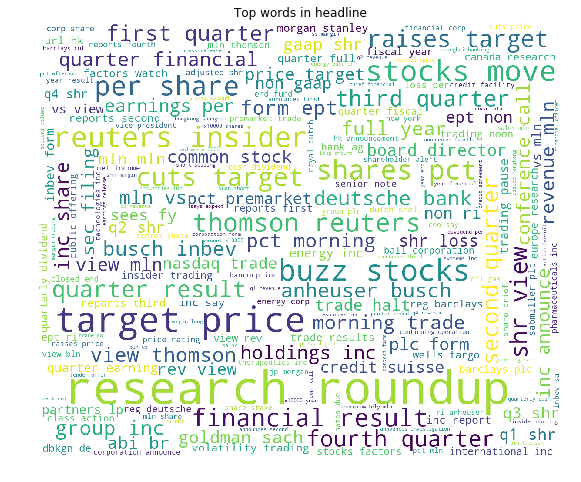

In [26]:
text = ' '.join(news_train_df['headline'].str.lower().values[-1000000:])
wordcloud = WordCloud(max_font_size=None, stopwords=stop, background_color='white',
                      width=1200, height=1000).generate(text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.title('Top words in headline')
plt.axis("off")
plt.show()

In [27]:
# Let's also limit the time period
news_train_df = news_train_df.loc[news_train_df['time'] >= '2009-01-01 22:00:00+0000']

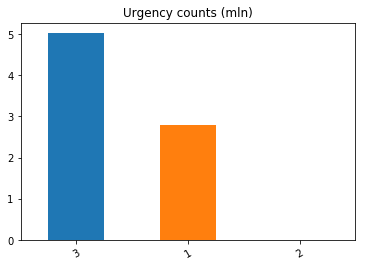

In [28]:
(news_train_df['urgency'].value_counts() / 1000000).plot('bar');
plt.xticks(rotation=30);
plt.title('Urgency counts (mln)');

So , urgency "2" is almost never used.

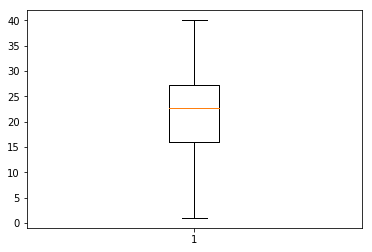

In [29]:
news_train_df['sentence_word_count'] =  news_train_df['wordCount'] / news_train_df['sentenceCount']
plt.boxplot(news_train_df['sentence_word_count'][news_train_df['sentence_word_count'] < 40]);

There are some big outliers, but sentences mostly have 15-25 words in them.

In [30]:
news_train_df['provider'].value_counts().head(10)

RTRS    6170570
PRN      554816
BSW      527318
GNW      153334
MKW      144532
LSE       64250
HIIS      58484
RNS       50254
CNW       35517
ONE       25233
Name: provider, dtype: int64

So, Reuters is the most common provider.

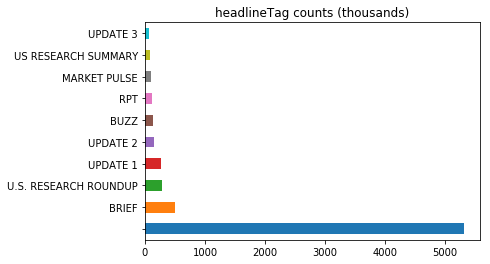

In [31]:
(news_train_df['headlineTag'].value_counts() / 1000)[:10].plot('barh');
plt.title('headlineTag counts (thousands)');

Most of the news are tagless.

In [32]:
for i, j in zip([-1, 0, 1], ['negative', 'neutral', 'positive']):
    df_sentiment = news_train_df.loc[news_train_df['sentimentClass'] == i, 'assetName']
    print(f'Top mentioned companies for {j} sentiment are:')
    print(df_sentiment.value_counts().head(5))
    print('')

Top mentioned companies for negative sentiment are:
JPMorgan Chase & Co        24262
Apple Inc                  24148
Bank of America Corp       23005
Citigroup Inc              22420
Goldman Sachs Group Inc    20570
Name: assetName, dtype: int64

Top mentioned companies for neutral sentiment are:
HSBC Holdings PLC    20799
Barclays PLC         15133
Deutsche Bank AG     14840
Credit Suisse AG     14632
Apple Inc            11921
Name: assetName, dtype: int64

Top mentioned companies for positive sentiment are:
Apple Inc                20533
Barclays PLC             19561
General Electric Co      16555
Royal Dutch Shell PLC    16369
Boeing Co                15289
Name: assetName, dtype: int64



## LGBM Modelling

In this part we will build a LightGBM with hyper-parameters tuned in random seed of 90 - 97.

We are using market data later than 2009 for trainig. In this LGBM model, we only use market data for training.

In [33]:
market_train = market_train.loc[market_train['time']>=date(2009, 1, 1)]
up = market_train.returnsOpenNextMktres10 >= 0
fcol = [c for c in market_train if c not in ['assetCode', 'assetCodes', 'assetCodesLen', 'assetName', 'audiences', 
                                             'firstCreated', 'headline', 'headlineTag', 'marketCommentary', 'provider', 
                                             'returnsOpenNextMktres10', 'sourceId', 'subjects', 'time', 'time_x', 'universe','sourceTimestamp']]

X = market_train[fcol].values
up = up.values
r = market_train.returnsOpenNextMktres10.values

# Scaling of X values
# It is good to keep these scaling values for later
mins = np.min(X, axis=0)
maxs = np.max(X, axis=0)
rng = maxs - mins
X = 1 - ((maxs - X) / rng)

# Sanity check
assert X.shape[0] == up.shape[0] == r.shape[0]

from sklearn import model_selection
from sklearn.metrics import mean_squared_error
import time

X_train, X_test, up_train, up_test, r_train, r_test = model_selection.train_test_split(X, up, r, test_size=0.25, random_state=99)
train_data_original = lgb.Dataset(X_train, label=up_train.astype(int))
test_data_original = lgb.Dataset(X_test, label=up_test.astype(int))

In [34]:
def split_data(seed):
    X_train, X_test, up_train, up_test, r_train, r_test = model_selection.train_test_split(X, up, r, test_size=0.25, random_state=seed)
    train_data = lgb.Dataset(X_train, label=up_train.astype(int))
    test_data = lgb.Dataset(X_test, label=up_test.astype(int))
    return train_data,test_data,X_test,up_test

def params(x) : 
    params = {'task': 'train',
        'boosting_type': 'dart',
        'objective': 'binary',
        'learning_rate': x[0],
        'num_leaves': x[1],
        'min_data_in_leaf': x[2],
        'num_iteration': x[3],
        'max_bin': x[4],
        'verbose': 1
             }
    return params

## Tuning hyper-params with skopt

In [ ]:
def generate_color():
    color = '#{:02x}{:02x}{:02x}'.format(*map(lambda x: np.random.randint(0, 255), range(3)))
    return color

df = pd.DataFrame({'imp': xgb_up.feature_importances_, 'col':fcol})
df = df.sort_values(['imp','col'], ascending=[True, False])
data = [df]
for dd in data:  
    colors = []
    for i in range(len(dd)):
         colors.append(generate_color())

    data = [
        go.Bar(
        orientation = 'h',
        x=dd.imp,
        y=dd.col,
        name='Features',
        textfont=dict(size=20),
            marker=dict(
            color= colors,
            line=dict(
                color='#000000',
                width=0.5
            ),
            opacity = 0.87
        )
    )
    ]
    layout= go.Layout(
        title= 'Feature Importance of XGBOOST',
        xaxis= dict(title='Columns', ticklen=5, zeroline=False, gridwidth=2),
        yaxis=dict(title='Value Count', ticklen=5, gridwidth=2),
        showlegend=True
    )

    py.iplot(dict(data=data,layout=layout), filename='horizontal-bar')

In [35]:
# define blackbox function
def f(x):
    print(x)
    gbm = lgb.train(params(x),
            train_data,
            num_boost_round=10,
            valid_sets=test_data,
            early_stopping_rounds=5)
            
    print(type(gbm.predict(X_test, num_iteration=gbm.best_iteration)[0]),type(up_test.astype(int)[0]))
    print('score: ', mean_squared_error(gbm.predict(X_test, num_iteration=gbm.best_iteration), up_test.astype(float)))
    return mean_squared_error(gbm.predict(X_test, num_iteration=gbm.best_iteration), up_test.astype(float))

def customize_optimization():
    res = gp_minimize(f, spaces,
    acq_func="EI",n_calls=30) # increase n_calls for more performance
    # print tuned params
    print(res.x)
    # plot tuning process
    # plot_convergence(res)
    return res.x

In [ ]:
# use this section if you want to customize optimization
# optimize params in these ranges
'''spaces = [
    (0.19, 0.20), #learning_rate
    (2450, 2600), #num_leaves
    (210, 230), #min_data_in_leaf
    (310, 330), #num_iteration
    (200, 220) #max_bin
    ]

all_res = []
for i in range(92,98):
    train_data,test_data,X_test,up_test= split_data(i)
    all_res.append(customize_optimization())'''

'''# run optimization
from skopt import gp_minimize
res = gp_minimize(
    f, spaces,
    acq_func="EI",
    n_calls=30) # increase n_calls for more performance

# print tuned params
print(res.x)

# plot tuning process
from skopt.plots import plot_convergence
plot_convergence(res)
'''

## Training with tuned params

In [36]:
# these are some tuned params I found

x1 = [0.19024791870973684, 2452, 211, 328, 218] #random seed 90
x2 = [0.19184519995243843, 2596, 210, 330, 201] #random seed 91
x3 = [0.19028318653395213, 2451, 211, 310, 202] #random seed 92
x4 = [0.1964045662030927, 2462, 223, 318, 203] #random seed 93
x5 = [0.1924689412581921, 2599, 211, 329, 200] #random seed 94
x6 = [0.19959482491896358, 2451, 228, 329, 218] #random seed 95
x7 = [0.19110356611831233, 2534, 216, 319, 219] #random seed 96
x8 = [0.1929977079965231, 2494, 224, 311, 214] #random seed 97

gbm_4 = lgb.train(params(x4),
        train_data_original,
        num_boost_round=100,
        valid_sets=test_data_original,
        early_stopping_rounds=5)

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning:

Found `num_iteration` in params. Will use it instead of argument



[1]	valid_0's binary_logloss: 0.690637
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.689101
[3]	valid_0's binary_logloss: 0.688086
[4]	valid_0's binary_logloss: 0.687378
[5]	valid_0's binary_logloss: 0.686938
[6]	valid_0's binary_logloss: 0.68663
[7]	valid_0's binary_logloss: 0.686464
[8]	valid_0's binary_logloss: 0.686527
[9]	valid_0's binary_logloss: 0.686334
[10]	valid_0's binary_logloss: 0.68621
[11]	valid_0's binary_logloss: 0.686055
[12]	valid_0's binary_logloss: 0.686031
[13]	valid_0's binary_logloss: 0.686004
[14]	valid_0's binary_logloss: 0.685998
[15]	valid_0's binary_logloss: 0.685924
[16]	valid_0's binary_logloss: 0.68595
[17]	valid_0's binary_logloss: 0.685911
[18]	valid_0's binary_logloss: 0.685801
[19]	valid_0's binary_logloss: 0.685814
[20]	valid_0's binary_logloss: 0.68563
[21]	valid_0's binary_logloss: 0.685608
[22]	valid_0's binary_logloss: 0.685301
[23]	valid_0's binary_logloss: 0.685305
[24]	valid_0's binary_logloss: 0

In [37]:
#prediction
days = env.get_prediction_days()

In [38]:
n_days = 0
prep_time = 0
prediction_time = 0
packaging_time = 0
for (market_obs_df, news_obs_df, predictions_template_df) in days:
    n_days +=1
    if (n_days%5==0):
        print(n_days,end=' ')
    t = time.time()
    market_obs_df = data_prep(market_obs_df)
    market_obs_df = market_obs_df[market_obs_df.assetCode.isin(predictions_template_df.assetCode)]
    X_live = market_obs_df[fcol].values
    X_live = 1 - ((maxs - X_live) / rng)
    prep_time += time.time() - t
    
    t = time.time()
    #lp = (gbm_1.predict(X_live) + gbm_2.predict(X_live) + gbm_3.predict(X_live) + gbm_4.predict(X_live))/4
    lp = gbm_4.predict(X_live) 
    prediction_time += time.time() -t
    
    t = time.time()

    confidence = lp
    confidence = (confidence-confidence.min())/(confidence.max()-confidence.min())
    confidence = confidence * 2 - 1
    preds = pd.DataFrame({'assetCode':market_obs_df['assetCode'],'confidence':confidence})
    predictions_template_df = predictions_template_df.merge(preds,how='left').drop('confidenceValue',axis=1).fillna(0).rename(columns={'confidence':'confidenceValue'})
    env.predict(predictions_template_df)
    packaging_time += time.time() - t
    
env.write_submission_file()
sub  = pd.read_csv("submission.csv")

5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265 270 275 280 285 290 295 300 305 310 315 320 325 330 335 340 345 350 355 360 365 370 375 380 385 390 395 400 405 410 415 420 425 430 435 440 445 450 455 460 465 470 475 480 485 490 495 500 505 510 515 520 525 530 535 540 545 550 555 560 565 570 575 580 585 590 595 600 605 610 615 620 625 630 635 Your submission file has been saved. Once you `Commit` your Kernel and it finishes running, you can submit the file to the competition from the Kernel Viewer `Output` tab.
